In [281]:
api_url = "https://brickset.com/api/v3.asmx/"
method = "getSets"
api_key = "apiKey=3-DVrd-qgkO-J2X5X"
user_hash = "userHash=89t9A2at23"
parameters = {'theme':'space','year':'1978,1979'}

url = api_url + method +"?"+ api_key + "&" + user_hash #+ "&"
print(url)

response = requests.get(url, params = parameters)
response.status_code, response.text#, print(response.json())

https://brickset.com/api/v3.asmx/getSets?apiKey=3-DVrd-qgkO-J2X5X&userHash=89t9A2at23


In [283]:
import json
with open("test.json") as f:
   data = json.load(f)
print(df_json)

(500,
 'System.InvalidOperationException: Missing parameter: params.\r\n   at System.Web.Services.Protocols.ValueCollectionParameterReader.Read(NameValueCollection collection)\r\n   at System.Web.Services.Protocols.UrlParameterReader.Read(HttpRequest request)\r\n   at System.Web.Services.Protocols.HttpServerProtocol.ReadParameters()\r\n   at System.Web.Services.Protocols.WebServiceHandler.CoreProcessRequest()\r\n')

# Lego Analysis

Author: M. Tosic
Date: 01.2022
This notebook is part of my capstone project for a data science course. The project is independent and has no connection to the company LEGO.

# 1. Business Understanding

Questions of interest

**General Discovery and Exploratory Analysis**
* What themes are dominant over the years?
* What words are used most often in set names?
* Most Minifigures?
* Most Lego pieces?
* Are lego sets becomming more and more expensive?
* Retial price to piece count?
* Does the value of sets go up after eol on average?
* What sets do best after eol? (eol = lego-term for end-of-life meaning the date when the set is not being produced anymore by the company).

**Predictive Analysis**
* What are features of the data set are good predictors that will rise in value after eol?
* What do the words contained in the set names tell us about the rise of value after eol.
* What sets that are currently being sold can I predicte to be a good investment after eol?* 

*e.g. price increase of at least 10 usd (for package and shipment when selling) + at least 25% profit

# 2. Data Understanding

Data being used in this notebook has been downloaded from the following sources:

* https://brickset.com/
* https://rebrickable.com/downloads/

Simplifications:
* No time series data on the price averages available. Assumption: price changes average out over time after eol. The price curves are already in a steady state.
* No data available on unique minifigs in sets (minifig are popular for collectors that focus on them and are generally believed to drive up the prices of some sets after eol).

### Import Libraries

In [403]:
import numpy as np
import pandas as pd

#cisualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100) #pd.set_option('display.max_rows', None)

# import necessary libraries for batch import csv:
import os
import glob

#to make api calls
import requests

### Import Data

In [143]:
df_sets = pd.read_csv('data/rebrickable-sets.csv')
df_themes = pd.read_csv('data/rebrickable-themes.csv')

In [321]:
def import_multiple_csv_files_2_df (relative_path):
    """ Function uses os and glob packages to import multiple csv files into one dataframe. 
    The current working directory should be the one where this notebook is located.
    INPUT: 
    Relative path to the files e.g. "./data/Kurac*.csv"
    OUTPUT: 
    One dataframe containting all csv files concatenated together over axis = 0.
    """
    path = os.getcwd()
    files = glob.glob(os.path.join(path, relative_path))
    
    print('Glob search with parameters:', relative_path)
   # print('Ingested files:')
    li = []
    for file in files:
        df_temp = pd.read_csv(file, index_col = None, header = 0)
        li.append(df_temp)
        #print(file)
    try:    
        df = pd.concat(li, axis=0, ignore_index=True)
        print('Done.')

    except:
        print('Something went wrong the concatenation of the files, returning None. Is the relative_path correctly set?')
        return(None)
    
    return (df)

In [322]:
df = import_multiple_csv_files_2_df("./data/Brickset*.csv")

Glob search with parameters: ./data/Brickset*.csv
Done.


In [323]:
#Droping unnessecary columns:
df.drop(['Qty owned','UPC','Qty owned new', 
         'Qty owned used', 'EAN','Priority','Wanted', 'Height', 'Depth', 'Weight', 'Width', 
         'Notes','Qty wanted','RRP (CAD)','Flag 1 not used', 'Flag 2 not used', 'Flag 3 not used',
         'Flag 4 not used', 'Flag 5 not used', 'Flag 6 not used','Flag 7 not used', 'Flag 8 not used'], axis=1, inplace=True)

In [324]:
#Adapting columns names to be able to user dot notation and more confortable coding (e.g. price instead of rrp)
df.rename(columns = lambda x : x.replace(' ', '_').replace('(','').replace(')','').lower().strip(), inplace = True)
df.rename(columns={'set':'set_name','rrp_usd': 'price', 'value_new_usd': 'value_new', 'value_used_usd':'value_used'});

In [325]:
#checking types per column
df.dtypes

number             object
theme              object
subtheme           object
year                int64
set_name           object
minifigs          float64
pieces            float64
rrp_gbp           float64
rrp_usd           float64
rrp_eur           float64
value_new_usd     float64
value_used_usd    float64
launch_date        object
exit_date          object
dtype: object

In [326]:
#Parse dates
#df['launch_date'] = pd.to_datetime(df['launch_date'])
#df['exit_date'] = pd.to_datetime(df['exit_date'])

In [329]:
#Exploring content
df.sort_values("year", inplace = True)

In [330]:
df.shape

(15634, 14)

In [404]:
df.describe()

year  minifigs    pieces  rrp_gbp   rrp_usd  rrp_eur  \
count 15,634.00  7,171.00 12,118.00 8,172.00 10,234.00 3,900.00   
mean   2,010.44      2.67    233.25    26.55     29.97    38.66   
std        8.05      2.79    470.34    39.71     44.52    56.64   
min    1,991.00      1.00      0.00     0.00      0.00     0.01   
25%    2,004.00      1.00     24.00     5.99      6.99     9.99   
50%    2,012.00      2.00     75.00    14.99     15.00    19.99   
75%    2,017.00      3.00    251.00    29.99     34.99    44.95   
max    2,022.00     33.00 11,695.00   699.99    799.99   799.99   

       value_new_usd  value_used_usd  
count      10,541.00        8,751.00  
mean           79.04           41.11  
std           213.08           75.64  
min             0.00            0.25  
25%            11.05            6.57  
50%            28.98           16.23  
75%            74.89           43.35  
max         9,773.99        1,391.39

In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15634 entries, 0 to 4101
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   number          15634 non-null  object 
 1   theme           15634 non-null  object 
 2   subtheme        12655 non-null  object 
 3   year            15634 non-null  int64  
 4   set_name        15634 non-null  object 
 5   minifigs        7171 non-null   float64
 6   pieces          12118 non-null  float64
 7   rrp_gbp         8172 non-null   float64
 8   rrp_usd         10234 non-null  float64
 9   rrp_eur         3900 non-null   float64
 10  value_new_usd   10541 non-null  float64
 11  value_used_usd  8751 non-null   float64
 12  launch_date     6624 non-null   object 
 13  exit_date       6624 non-null   object 
dtypes: float64(7), int64(1), object(6)
memory usage: 1.8+ MB


**Check if there are duplicated values:**

In [400]:
df[df.duplicated()]

Empty DataFrame
Columns: [number, theme, subtheme, year, set_name, minifigs, pieces, rrp_gbp, rrp_usd, rrp_eur, value_new_usd, value_used_usd, launch_date, exit_date]
Index: []

**Unique values per column:**

In [401]:
df.nunique().sort_values(ascending = True)

minifigs             31
year                 32
theme               141
rrp_eur             143
exit_date           165
rrp_gbp             270
rrp_usd             322
launch_date         404
subtheme            801
pieces             1332
value_used_usd     4522
value_new_usd      6178
set_name          13328
number            15634
dtype: int64

**Investigate missing values in data set:**

In [333]:
print("Percentages of missing values:\n{}".format(df.isnull().sum()/df.shape[0]*100))

Percentages of missing values:
number             0.000000
theme              0.000000
subtheme          19.054625
year               0.000000
set_name           0.000000
minifigs          54.132020
pieces            22.489446
rrp_gbp           47.729308
rrp_usd           34.540105
rrp_eur           75.054369
value_new_usd     32.576436
value_used_usd    44.025841
launch_date       57.630805
exit_date         57.630805
dtype: float64


In [381]:
df_missing_val_per = pd.DataFrame(df.isnull().sum()/df.shape[0]*100, columns=['value'])

In [383]:
df_missing_val_per_sorted = df_missing_val_per.sort_values(by = "value", ascending = False)

In [387]:
px.bar(df_missing_val_per_sorted, x = df_missing_val_per_sorted.index, y = "value", labels = {"value":"Percentage of missing values"})


**Comments:**
* There are NaN values in multiple columns.
* Most values are missing in rrp_eur, but this is ok since the analysis will be done in usd (due to value_new and value_used being in usd). The available rrp_eur values can be used to fill-in missing data in the usd column.
* More than half of the items don't have a launch and exit date.
* The missing values for minifigs could just be due to the items being lego sets without any minifigures or those are other lego product merchendise.

**Tasks:**
* A quarter of the items are missing piece counts. This must be investigated since it could indicate the item is not a lego set but some other kind of merchandise from the database. I will aim to categorize the items into sets and other merchendise. A possible way to does this is to use the pieces count >0 or minifigure >0.

* Most prices are available in usd, also the value new and used is available in usd. If possible I will try to calculate missing values in usd by the columns of other currencies then drop the other columns to reduce complexity for further processing (one currency is enough for the inteded analysis).

* Also some dates are missing, I'll take a look at that. Sets from 2022 have probably not yet been released, I will label them as not released. The items that have a launch date but no exit date will be labeled as active, items that have an exit date will be label eol (popular lego term "end-of-life" for items that are no longer produced).

**Make box-plots of all columns with numerival values:**

In [389]:
for col in df.columns:
    if df[col].dtype == np.int64 or df[col].dtype == np.float64:
        print(col)
        fig = px.box(df, x = col)#, color = )
        fig.update_yaxes(visible = False, showticklabels = False)
        fig.show()
    else:
        continue

year


minifigs


pieces


rrp_gbp


rrp_usd


rrp_eur


value_new_usd


value_used_usd


**Comments**
* Year: The median is 2012 meaning that half of the items in the data-set containing the past 30th years were released in the past 9 years.
* Minifing: Median is only 2. This should be investigated in more detail since data set includes lego items that are not necessarily sets but other merchandice.
* Pieces: Similare goes for the rather low median of pieces. 

**Task**
* Task categorize entries as sets very other merchandice.

In [397]:
px.scatter(df, x = "year", y = "theme", color = "theme")

In [398]:
px.histogram(df.groupby("year"), x = df.launch_date, y = df.year)

<AxesSubplot:>

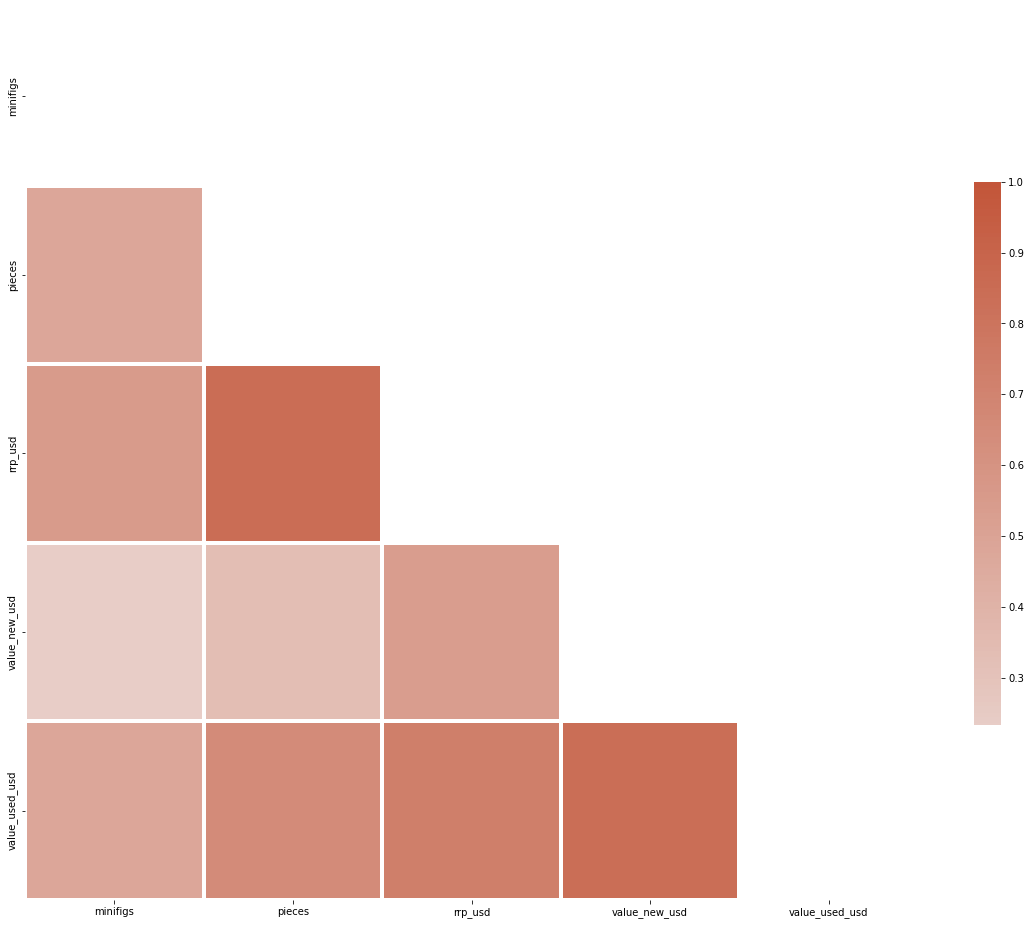

In [399]:
corr = df.drop(["year","rrp_gbp","rrp_eur"], axis = "columns").corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

f, ax = plt.subplots(figsize = (20,20))

cmap = sns.diverging_palette(230, 20, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, linewidth = 4, cbar_kws = {"shrink":.5})


### Missing piece count: 

In [182]:
df[df.pieces.isnull()].head(100)

number                    theme                             subtheme  \
5      10282-2           Creator Expert                               Adidas   
58     11956-1            Miscellaneous                                  NaN   
59     11957-1            Miscellaneous                                  NaN   
137    40458-1              Promotional                           LEGO House   
162    40489-1                 Seasonal                            Christmas   
253    43101-0                   Vidiyo                   Bandmates Series 1   
267   43101-14                   Vidiyo                   Bandmates Series 1   
274    43108-0                   Vidiyo                   Bandmates Series 2   
288   43108-14                   Vidiyo                   Bandmates Series 2   
311    45345-1                Education                      SPIKE Essential   
314    45607-1                Education                          SPIKE Prime   
315    45608-1                Education                          SPIKE Prime   
316    45609-1                Education                          SPIKE Prime   
319    45816-1                Education                    FIRST LEGO League   
320    45817-1                Education                    FIRST LEGO League   
321    45818-1                Education                FIRST LEGO League Jr.   
364    66673-1                  Friends                   Product Collection   
365    66674-1                Star Wars                   Product Collection   
367    66678-1  Collectable Minifigures                       Marvel Studios   
371    71029-0  Collectable Minifigures                            Series 21   
385   71029-14  Collectable Minifigures                            Series 21   
386    71030-0  Collectable Minifigures                         Looney Tunes   
400   71030-14  Collectable Minifigures                         Looney Tunes   
401    71031-0  Collectable Minifigures                       Marvel Studios   
415   71031-14  Collectable Minifigures                       Marvel Studios   
422    71386-0              Super Mario            Character Pack - Series 2   
423    71386-1              Super Mario            Character Pack - Series 2   
424    71386-2              Super Mario            Character Pack - Series 2   
425    71386-3              Super Mario            Character Pack - Series 2   
426    71386-4              Super Mario            Character Pack - Series 2   
427    71386-5              Super Mario            Character Pack - Series 2   
428    71386-6              Super Mario            Character Pack - Series 2   
429    71386-7              Super Mario            Character Pack - Series 2   
430    71386-8              Super Mario            Character Pack - Series 2   
431    71386-9              Super Mario            Character Pack - Series 2   
432   71386-10              Super Mario            Character Pack - Series 2   
434   71386-12              Super Mario            Character Pack - Series 2   
442    71394-0              Super Mario            Character Pack - Series 3   
443    71394-1              Super Mario            Character Pack - Series 3   
444    71394-2              Super Mario            Character Pack - Series 3   
445    71394-3              Super Mario            Character Pack - Series 3   
446    71394-4              Super Mario            Character Pack - Series 3   
447    71394-5              Super Mario            Character Pack - Series 3   
448    71394-6              Super Mario            Character Pack - Series 3   
449    71394-7              Super Mario            Character Pack - Series 3   
450    71394-8              Super Mario            Character Pack - Series 3   
451    71394-9              Super Mario            Character Pack - Series 3   
452   71394-10              Super Mario            Character Pack - Series 3   
454   71394-12              Super Mario            Character Pack - Series 3   
613   30

The subset of rows contains different lego products that are not lego sets, such as shoes, pens etc. Also there are some sets that where never publish such as the Seasonal Christmas set Mr. and Mrs. Claus' Living Room.

Also there are various minifigure series.

In [82]:
set(df.theme)

{'4 Juniors',
 'Action Wheelers',
 'Adventurers',
 'Agents',
 'Alpha Team',
 'Aqua Raiders',
 'Architecture',
 'Art',
 'Atlantis',
 'Avatar The Last Airbender',
 'Baby',
 'Basic',
 'Batman',
 'Belville',
 'Ben 10: Alien Force',
 'Bionicle',
 'Books',
 'Boost',
 'Brick Sketches',
 'BrickHeadz',
 'Bricklink',
 'Bricks and More',
 'Bulk Bricks',
 'Cars',
 'Castle',
 'City',
 'Classic',
 'Clikits',
 'Collectable Minifigures',
 'Creator',
 'Creator Expert',
 'DC Comics Super Heroes',
 'DC Super Hero Girls',
 'Dacta',
 'Dimensions',
 'Dino',
 'Dino 2010',
 'Dino Attack',
 'Dinosaurs',
 'Discovery',
 'Disney',
 'Dots',
 'Duplo',
 'Education',
 'Elves',
 'Exo-Force',
 'Explore',
 'FORMA',
 'Factory',
 'Friends',
 'Fusion',
 'Galidor',
 'Games',
 'Gaming',
 'Gear',
 'Ghostbusters',
 'HERO Factory',
 'Harry Potter',
 'Hidden Side',
 'Hobby Set',
 'Ideas',
 'Indiana Jones',
 'Island Xtreme Stunts',
 'Jack Stone',
 'Juniors',
 'Jurassic World',
 'Legends of Chima',
 'Life of George',
 'Make and Cr

In [163]:
#def remove_rows_with_column_values (column, list_of_values = [])
    
cols_to_remove = ["Books"]

df[df.theme == "Books"].head()

number  theme            subtheme  year                  set_name  \
829    5006978-1  Books  Dorling Kindersley  2021  Masters' Book of Secrets   
883  BLOCKS075-1  Books    Magazines/Blocks  2021  Blocks magazine issue 75   
884  BLOCKS076-1  Books    Magazines/Blocks  2021  Blocks magazine issue 76   
885  BLOCKS077-1  Books    Magazines/Blocks  2021  Blocks magazine issue 77   
886  BLOCKS078-1  Books    Magazines/Blocks  2021  Blocks magazine issue 78   

     minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  \
829       NaN     NaN      NaN      NaN      NaN            NaN   
883       NaN     NaN      NaN      NaN      NaN            NaN   
884       NaN     NaN      NaN      NaN      NaN            NaN   
885       NaN     NaN      NaN      NaN      NaN            NaN   
886       NaN     NaN      NaN      NaN      NaN            NaN   

     value_used_usd launch_date exit_date  
829             NaN         NaN       NaN  
883             NaN         NaN       NaN  
884             NaN         NaN       NaN  
885             NaN         NaN       NaN  
886             NaN         NaN       NaN

In [169]:
set(df.number)

{'81007-1',
 '851876-1',
 '852021-1',
 '70338-1',
 '5489-1',
 '3727-1',
 '4621-1',
 '41514-1',
 '8115-1',
 '10191-1',
 '4032-6',
 '30063-0',
 '21303-1',
 '5004612-1',
 '4499395-1',
 '6910-1',
 '4559387-1',
 '40413-1',
 '3947-1',
 '4893-1',
 '5000438-1',
 '853209-1',
 '850815-1',
 '10955-1',
 '4876-1',
 '71023-11',
 '891950-1',
 '853602-1',
 '8259-1',
 '5002123-1',
 '952107-1',
 '6373603-1',
 '66333-1',
 '4566-1',
 '20210-1',
 '71769-1',
 '41490-1',
 '892063-1',
 '66193-1',
 '66379-1',
 '911839-1',
 '71303-1',
 '9472-1',
 '75261-1',
 '2856217-1',
 '42089-1',
 '41428-1',
 '8683-15',
 '71019-15',
 '8554-1',
 '2852725-1',
 '5004849-1',
 '7503-1',
 '70618-1',
 '3920-1',
 '8002-1',
 '41550-1',
 '5005713-1',
 '60104-1',
 '8831-13',
 '853346-1',
 '561905-1',
 '71010-3',
 '71008-13',
 '4466-1',
 '21154-1',
 '21335-1',
 '9545-1',
 '851015-1',
 '852688-1',
 '10847-1',
 'HPG04-1',
 '8758-1',
 '4057-1',
 'ISBN9781470108106-1',
 'M8465934-1',
 '8684-6',
 '40464-1',
 '10581-1',
 'BLOCKS076-1',
 '7198

In [ ]:
[a-zA-Z]

I'm only interested in lego sets not books and additional gear. 

So how do I filter those out of the dataset as easy as possible? 

According to information from Lego.com, the sets always have a unique number. I will use this to filter out the categories that have characters. in the column "number".

In [ ]:

My assumption is that the sets that contain no pieces are not proper lego sets but rather gear. Also I would like to remove any unreleased items, that would be items with no launch date.



In [ ]:
df[df.pieces.isnull()]

In [76]:
def make_bar_chart(df,x_val,y_val,title_string = "",labels_dict = {}):
    '''Function uses plotly.express to create a bar chart and show it in the notebook right-away.
    INPUT
    df: dataframe to be visualizes in bar chart
    x_val: column to be represented on x-axis
    y_val: column to be represented on y-axis
    title_string: the title as a string
    labels_dict: labels can be renamed by entering a dictionary.
    OUTPUT
    None
    '''
    fig = px.bar(df, x_val, y_val, 
            title=title_string, 
            labels=labels_dict)
   # fig.show()
    return fig

In [176]:
make_bar_chart(df,df.theme,df.year)

In [141]:
#Could be needed later 

df.dropna(subset=["minifigs","pieces","rrp_gbp",
                  "rrp_eur","rrp_usd","value_used_usd",
                  "launch_date", "exit_date"], how='all').shape

(12600, 14)

## 3. Prepare Data

## 4. Analysis

## 5. Evaluation